## Comparative study of machine-learning models for breast cancer diagnosis

The objective of this notebook is to build and compare several supervised classification models for **breast cancer diagnosis** using the Wisconsin Diagnostic Breast Cancer (WDBC) dataset. Each observation corresponds to a breast mass, described by 30 quantitative features extracted from digitised images of fine-needle aspirates (FNA). The target variable indicates whether the tumour is **benign** or **malignant**.

From a clinical perspective, the cost of errors is asymmetric:

- **False negatives** (malignant predicted as benign) are critical, because they correspond to missed cancers.
- **False positives** (benign predicted as malignant) lead to unnecessary anxiety and additional examinations.

For this reason, the analysis will not only report accuracy, but also **recall, precision, F1-score, ROC-AUC**, and will explicitly discuss threshold tuning and the trade-off between sensitivity and specificity.

### Models under comparison

We focus on three widely used classifiers:

1. **Logistic Regression**  
   A linear probabilistic model with L2 regularisation. It offers good baseline performance and interpretable coefficients that quantify the contribution of each feature to the log-odds of malignancy.

2. **Support Vector Machine (SVM) with RBF kernel**  
   A large-margin classifier capable of learning non-linear decision boundaries through the RBF kernel. It is particularly suited to problems where classes are not linearly separable in the original feature space.

3. **Random Forest**  
   An ensemble of decision trees trained with bootstrap sampling and random feature selection. It can naturally model non-linear interactions and provides feature importance measures based on impurity reduction.

### Methodological pipeline

To ensure a rigorous and reproducible comparison, the notebook follows a structured end-to-end pipeline:

1. **Data loading** from the ARFF file.
2. **Data cleaning and basic feature engineering**  
   – decoding byte columns, renaming features to their official WDBC names, recoding the diagnosis into a binary label.
3. **Exploratory Data Analysis (EDA)**  
   – descriptive statistics, class distribution, univariate and bivariate visualisations, correlation analysis.
4. **Feature matrix and target definition**, followed by a **stratified train–test split** to keep class proportions consistent.
5. **Class imbalance handling** using **SMOTE** on the training set only.
6. **Feature scaling** (standardisation) for models that are sensitive to feature magnitudes (Logistic Regression and SVM).
7. **Model training and cross-validation** on the training data for each algorithm.
8. **Hyperparameter optimisation** with cross-validated grid search (GridSearchCV).
9. **Test set evaluation** of the best configurations, including ROC curves and confusion matrices.
10. **Decision-threshold calibration** using precision/recall/F1 vs threshold.
11. **Feature importance and interpretability** (coefficients, impurity-based importance, permutation importance).
12. **Model comparison and final recommendation** with a focus on clinically relevant trade-offs.

The rest of the notebook walks through these steps in detail, justifying each preprocessing decision and explaining the behaviour of the three models both from a statistical and a clinical point of view.


In [1]:
# ============================================================
# 0. Imports and global configuration
# ============================================================

import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="sklearn"
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

plt.style.use("default")
plt.rcParams["figure.dpi"] = 100  # reasonably compact figures


### 1. Data loading

In this section we load the WDBC breast cancer dataset from an ARFF file using `scipy.io.arff` and convert it to a pandas `DataFrame`.  

Key points from the raw preview:

- The dataset has **569 rows** and **31 columns**.
- Columns `V1` to `V30` are already numeric (`float64`), which is convenient for most machine-learning algorithms.
- The `Class` column is stored as an `object` type with values such as `b'1'` and `b'2'`, i.e., byte strings that will need decoding and recoding before modeling.

At this stage, we only want to confirm that:
1. The file is read correctly.
2. The number of rows/columns matches the expected WDBC dataset.
3. The target column is present and identifiable as `Class`.


In [2]:
# ============================================================
# 1. Data loading
# ============================================================

# Update this path to the actual location of your ARFF file
file_path = "/Users/HAMZA OUBA/Desktop/project/Data/phpAmSP4g.arff"

# Load ARFF file and convert to a pandas DataFrame
data, meta = arff.loadarff(file_path)
df_raw = pd.DataFrame(data)

print("=== Raw data preview (first 5 rows) ===")
print(df_raw.head(), "\n")

print("Dataset dimensions (raw):")
print(f"- Number of rows:    {df_raw.shape[0]}")
print(f"- Number of columns: {df_raw.shape[1]}\n")

print("Column types (before cleaning):")
print(df_raw.dtypes, "\n")


=== Raw data preview (first 5 rows) ===
      V1     V2      V3      V4       V5       V6      V7       V8      V9  \
0  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001  0.14710  0.2419   
1  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869  0.07017  0.1812   
2  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974  0.12790  0.2069   
3  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414  0.10520  0.2597   
4  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980  0.10430  0.1809   

       V10  ...    V22     V23     V24     V25     V26     V27     V28  \
0  0.07871  ...  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.05667  ...  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.05999  ...  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.09744  ...  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.05883  ...  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

      V29      V30  Class  
0  0.4601  0.11890

### 2. Data cleaning and basic feature engineering

The goal of this block is to transform the raw ARFF table into a clean, analysis-ready dataset:

1. **Decode byte columns**  
   ARFF often stores categorical strings as bytes. We iterate over all columns and, when a column is of type `object`, we try to decode it from UTF-8.  
   After this step, the `Class` column is converted from `b'1'` / `b'2'` to simple string values `"1"` and `"2"`.

2. **Rename feature columns to WDBC names**  
   The original WDBC dataset defines 30 features describing cell nuclei morphology (e.g. `radius_mean`, `texture_mean`, `concavity_worst`).  
   We map generic names `V1`..`V30` to these official feature names and rename `Class` to `diagnosis`.  
   This greatly improves interpretability later, especially when we discuss model coefficients and feature importance.

3. **Recode the target to a binary numeric label**  
   In this file, `"1"` corresponds to **benign** and `"2"` to **malignant**.  
   We create a new target encoding:
   - `0` → benign  
   - `1` → malignant  
   and we keep `diagnosis_original` as a trace of the original coding.

4. **Check for missing values**  
   We compute, and assert, that there are **no missing values** in any column.  
   This means we can proceed directly to EDA and modeling without imputation.

After this block, we have:
- A clean `DataFrame` with **30 named numeric features**.
- A binary numeric target `diagnosis` ∈ {0, 1}.  
This is the canonical format expected by most scikit-learn classifiers.


In [3]:
# ============================================================
# 2. Data cleaning and basic feature engineering
#    - Decode byte columns
#    - Rename feature columns to WDBC names
#    - Recode target 'diagnosis' to 0/1
# ============================================================

df = df_raw.copy()

# Decode byte columns (ARFF often loads string columns as bytes)
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = df[col].str.decode("utf-8")
        except Exception:
            # If decoding fails, leave the column as is
            pass

print("=== After potential decoding of byte columns ===")
print(df.head(), "\n")

# Official WDBC feature names (30 features)
feature_names = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean",
    "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se",
    "smoothness_se", "compactness_se", "concavity_se",
    "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst",
    "smoothness_worst", "compactness_worst", "concavity_worst",
    "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]

# Map generic V1..V30 + Class -> WDBC feature names + diagnosis
rename_map = {f"V{i+1}": feature_names[i] for i in range(30)}
rename_map["Class"] = "diagnosis"

df = df.rename(columns=rename_map)

print("=== Column names after renaming ===")
print(df.columns.tolist(), "\n")

# Recode target: in this file '1' = benign, '2' = malignant
print("=== Unique values of diagnosis BEFORE recoding ===")
print(df["diagnosis"].unique(), "\n")

# Keep original coding for traceability
df["diagnosis_original"] = df["diagnosis"]

df["diagnosis"] = df["diagnosis"].map({
    "1": 0,   # benign
    "2": 1    # malignant
})

print("=== Unique values of diagnosis AFTER recoding ===")
print(df["diagnosis"].unique(), "\n")

# Check for missing values
missing = df.isna().sum()
print("=== Missing values per column ===")
print(missing, "\n")
print("Total number of missing values:", missing.sum(), "\n")

# For this project, we enforce that there should be no missing values
assert missing.sum() == 0, "There are missing values in the dataset. They must be handled before modeling."


=== After potential decoding of byte columns ===
      V1     V2      V3      V4       V5       V6      V7       V8      V9  \
0  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001  0.14710  0.2419   
1  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869  0.07017  0.1812   
2  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974  0.12790  0.2069   
3  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414  0.10520  0.2597   
4  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980  0.10430  0.1809   

       V10  ...    V22     V23     V24     V25     V26     V27     V28  \
0  0.07871  ...  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.05667  ...  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.05999  ...  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.09744  ...  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.05883  ...  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

      V29      V30  Class  
0  0.4601

### 3. Exploratory data analysis (EDA)

The objective of this section is to understand the structure of the cleaned dataset, the distribution of the target, and the behaviour of a few key features.




=== Summary statistics for numeric features ===
       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380  

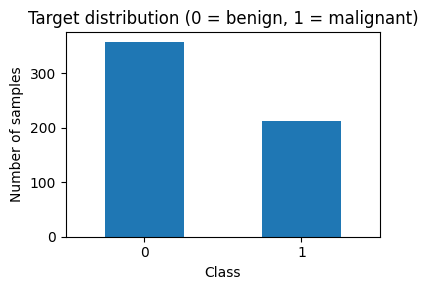

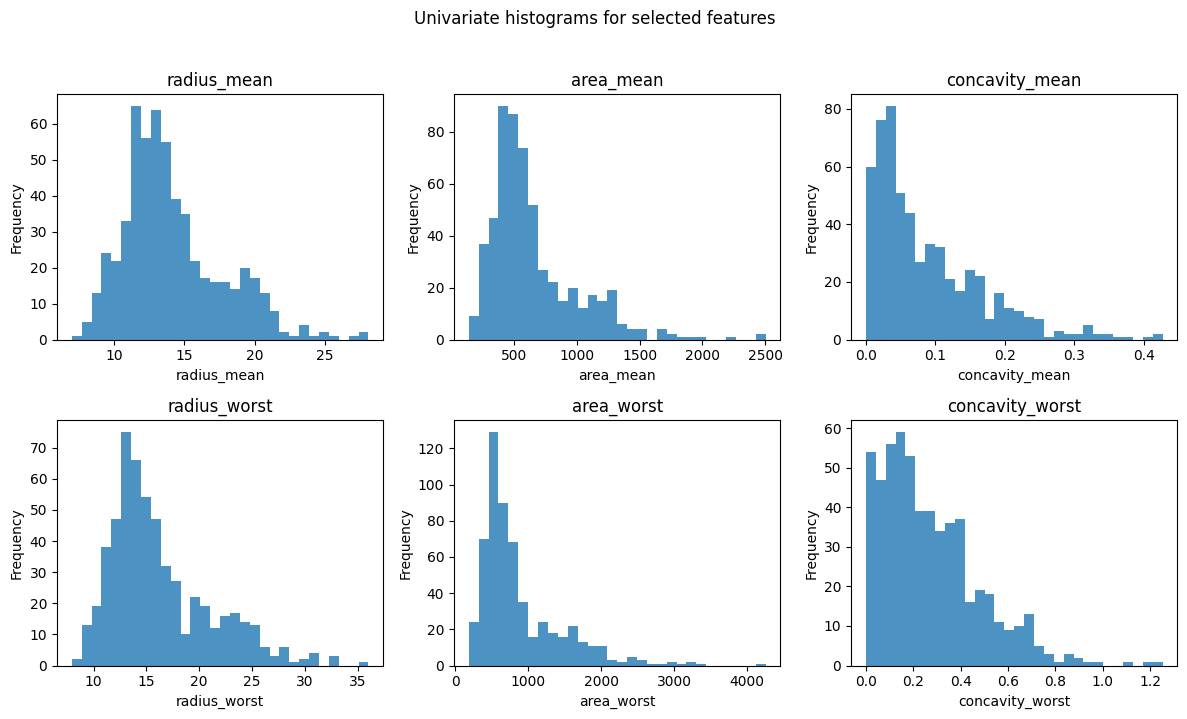

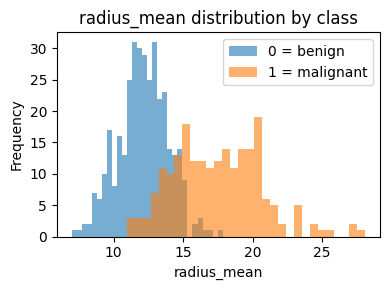

C:\Users\HAMZA OUBA\AppData\Local\Temp\ipykernel_1352\151099430.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=["0 = benign", "1 = malignant"])


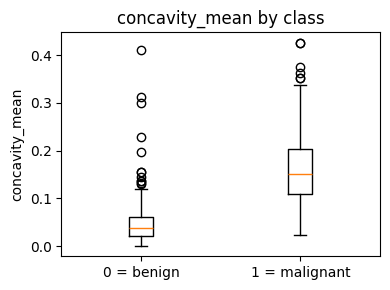

=== Correlation matrix sample (5x5) ===
                 radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean         1.000000      0.323782        0.997855   0.987357   
texture_mean        0.323782      1.000000        0.329533   0.321086   
perimeter_mean      0.997855      0.329533        1.000000   0.986507   
area_mean           0.987357      0.321086        0.986507   1.000000   
smoothness_mean     0.170581     -0.023389        0.207278   0.177028   

                 smoothness_mean  
radius_mean             0.170581  
texture_mean           -0.023389  
perimeter_mean          0.207278  
area_mean               0.177028  
smoothness_mean         1.000000   



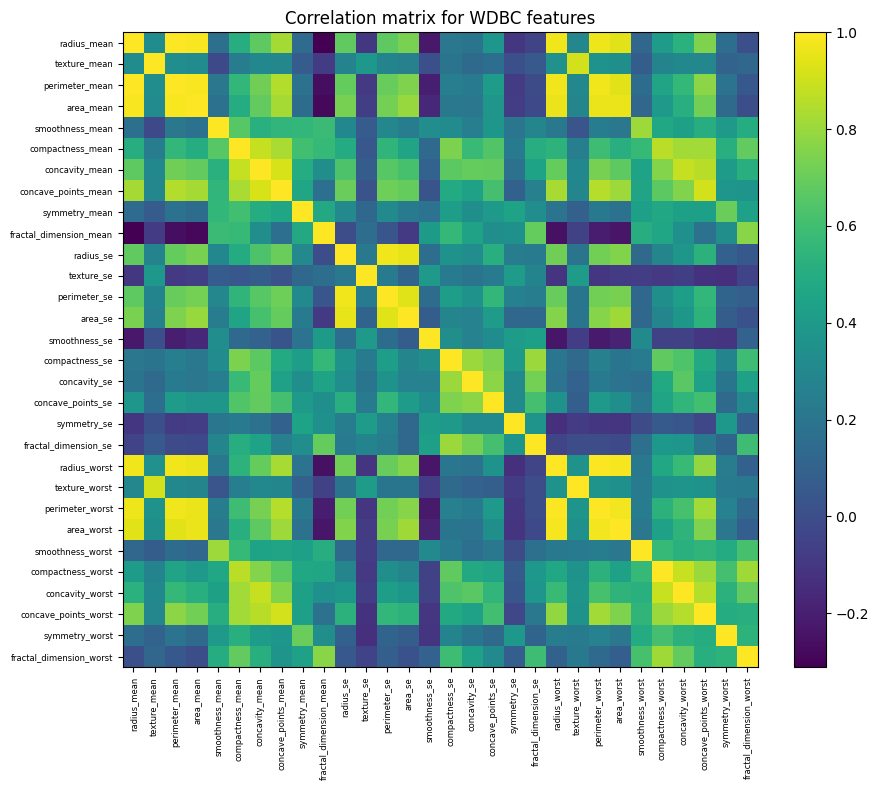

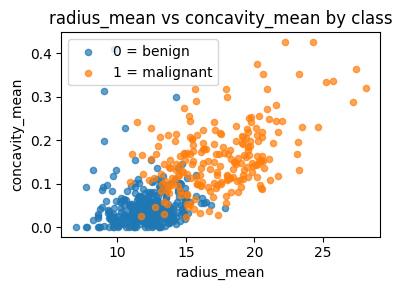

In [4]:
# ============================================================
# 3. Exploratory data analysis (EDA)
# ============================================================

print("=== Summary statistics for numeric features ===")
print(df[feature_names].describe(), "\n")

# ------------------------------------------------------------
# 3.1 Target distribution
# ------------------------------------------------------------

class_counts = df["diagnosis"].value_counts().sort_index()
print("=== Class distribution (0 = benign, 1 = malignant) ===")
print(class_counts)
print("\nClass distribution in %:")
print((class_counts / class_counts.sum()) * 100, "\n")

plt.figure(figsize=(4, 3))
class_counts.plot(kind="bar")
plt.title("Target distribution (0 = benign, 1 = malignant)")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 3.2 Histograms 
# ------------------------------------------------------------

def plot_hist_grid(df_in, cols, bins=30, n_cols=3, figsize=(12, 3.5)):
    """
    Plot univariate histograms for a list of numeric columns, arranged
    in a grid with n_cols plots per row.
    """
    n_features = len(cols)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    for idx, col in enumerate(cols):
        r = idx // n_cols
        c = idx % n_cols
        ax = axes[r, c]

        ax.hist(df_in[col], bins=bins, alpha=0.8)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

    # Hide any unused subplots
    for j in range(n_features, n_rows * n_cols):
        r = j // n_cols
        c = j % n_cols
        axes[r, c].axis("off")

    fig.suptitle("Univariate histograms for selected features", y=1.02)
    plt.tight_layout()
    plt.show()


features_to_plot = [
    "radius_mean", "area_mean", "concavity_mean",
    "radius_worst", "area_worst", "concavity_worst"
]

plot_hist_grid(df, features_to_plot, bins=30, n_cols=3, figsize=(12, 3.5))


# ------------------------------------------------------------
# 3.3 Example: radius_mean distribution by class
# ------------------------------------------------------------

benign = df[df["diagnosis"] == 0]["radius_mean"]
malignant = df[df["diagnosis"] == 1]["radius_mean"]

plt.figure(figsize=(4, 3))
plt.hist(benign, bins=30, alpha=0.6, label="0 = benign")
plt.hist(malignant, bins=30, alpha=0.6, label="1 = malignant")
plt.title("radius_mean distribution by class")
plt.xlabel("radius_mean")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 3.4 Boxplot: concavity_mean by class
# ------------------------------------------------------------

plt.figure(figsize=(4, 3))
data_to_plot = [
    df[df["diagnosis"] == 0]["concavity_mean"],
    df[df["diagnosis"] == 1]["concavity_mean"]
]
plt.boxplot(data_to_plot, labels=["0 = benign", "1 = malignant"])
plt.title("concavity_mean by class")
plt.ylabel("concavity_mean")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 3.5 Correlation matrix for the 30 WDBC features
# ------------------------------------------------------------

corr_matrix = df[feature_names].corr()

print("=== Correlation matrix sample (5x5) ===")
print(corr_matrix.iloc[:5, :5], "\n")

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap="viridis")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation matrix for WDBC features")

ticks = np.arange(len(feature_names))
plt.xticks(ticks, feature_names, rotation=90, fontsize=6)
plt.yticks(ticks, feature_names, fontsize=6)

plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 3.6 2D scatter: radius_mean vs concavity_mean, colored by class
# ------------------------------------------------------------

plt.figure(figsize=(4, 3))
colors = {0: "blue", 1: "orange"}
labels = {0: "0 = benign", 1: "1 = malignant"}

for cls in [0, 1]:
    subset = df[df["diagnosis"] == cls]
    plt.scatter(
        subset["radius_mean"],
        subset["concavity_mean"],
        alpha=0.7,
        label=labels[cls],
        s=20
    )

plt.xlabel("radius_mean")
plt.ylabel("concavity_mean")
plt.title("radius_mean vs concavity_mean by class")
plt.legend()
plt.tight_layout()
plt.show()



#### 3.1 Summary statistics

The descriptive statistics show:

- `radius_mean`, `area_mean`, `concavity_mean`, etc. have strictly positive values with a **right-skewed** distribution (max values much larger than the median).  
- The range of some features is quite wide (e.g. `area_mean` from 143.5 to 2501), which later justifies feature scaling before using distance-based models or regularized linear models.

This summary helps us confirm that:
- There are no obvious anomalies (e.g. negative areas).
- The magnitudes of features differ significantly, so standardisation will be important.

#### 3.2 Target distribution (bar plot)

The target distribution plot shows:

- **357 benign** cases (`0`)  
- **212 malignant** cases (`1`)  

So the dataset is **moderately imbalanced** (~63% benign vs ~37% malignant).  
This level of imbalance is not extreme, but it is enough to consider techniques like **SMOTE** on the training set and to pay attention to metrics beyond accuracy (recall, F1, ROC-AUC).

#### 3.3 Univariate histograms (6 panels, 3 per row)

The grid of histograms for  
`radius_mean`, `area_mean`, `concavity_mean`, `radius_worst`, `area_worst`, `concavity_worst`  
shows:

- All these features are **right-skewed**: most tumours have relatively small values, with a long tail of larger, more aggressive tumours.
- The “worst” features (`*_worst`) typically have higher ranges than the corresponding “mean” features, capturing more extreme morphology.

These shapes confirm that:
- Simple Gaussian assumptions on raw features would be questionable.
- Non-linear models (SVM RBF, Random Forest) and scaling can be beneficial.

#### 3.4 `radius_mean` distribution by class (overlapping histograms)

The overlapping histograms by class highlight a clear pattern:

- Benign tumours cluster at **smaller radii**, roughly around 10–14.
- Malignant tumours are shifted to the right, with a higher concentration above roughly 15.

Even though there is some overlap, the shift suggests that `radius_mean` alone has strong discriminative power, which we will see later in feature importance.

#### 3.5 `concavity_mean` boxplot by class

The boxplot of `concavity_mean` for benign vs malignant tumours shows:

- The **median concavity** is much **higher** for malignant tumours.
- The entire distribution for malignant samples is shifted upward, with many large values and several high outliers.
- Benign tumours have low concavity with relatively tight dispersion.

This supports the clinical intuition that malignant tumours have more irregular and concave borders.

#### 3.6 Correlation matrix heatmap (30×30)

The correlation matrix reveals:

- Very high positive correlations between `radius_mean`, `perimeter_mean`, `area_mean`, and their “worst” counterparts.  
  These features represent related aspects of tumour size and shape.
- Blocks of correlated features indicate **redundancy**, which:
  - is not a problem for tree-based methods (Random Forest),
  - but matters for linear models, where correlated features can share or compete for coefficient weight.

Understanding these correlations helps interpret model coefficients later and also motivates regularisation.

#### 3.7 Scatter plot: `radius_mean` vs `concavity_mean` by class

The scatter plot shows:

- Benign tumours cluster in the lower-left region (smaller radius and low concavity).
- Malignant tumours occupy a more spread region with **larger radius** and **higher concavity**.
- There is still some overlap, but the classes are already fairly well separated in this 2-D projection.

This confirms that combining size and border irregularity provides a strong signal for malignancy.


### 4. Feature matrix, target vector, and train–test split

In this section we:

1. Build the **feature matrix** `X` using the 30 WDBC features.
2. Set the **target vector** `y` to the binary diagnosis label.
3. Perform a **stratified train–test split**:
   - 80% of the data for training (and validation),
   - 20% for final evaluation,
   - `stratify=y` ensures that class proportions are preserved in both sets.



Shapes:
X: (569, 30)
y: (569,) 

X_train: (455, 30)
X_test : (114, 30)
y_train: (455,)
y_test : (114,) 

Global class distribution:
diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64 

Class distribution in y_train:
diagnosis
0    0.626374
1    0.373626
Name: proportion, dtype: float64 

Class distribution in y_test:
diagnosis
0    0.631579
1    0.368421
Name: proportion, dtype: float64 



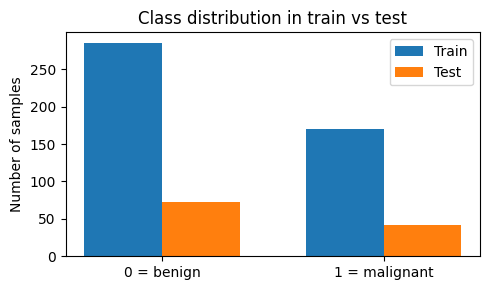

In [5]:
# ============================================================
# 4. Feature matrix, target vector, and train–test split
# ============================================================

X = df[feature_names]
y = df["diagnosis"]

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape, "\n")

# Stratified split to preserve the class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape, "\n")

print("Global class distribution:")
print(y.value_counts(normalize=True), "\n")

print("Class distribution in y_train:")
print(y_train.value_counts(normalize=True), "\n")

print("Class distribution in y_test:")
print(y_test.value_counts(normalize=True), "\n")

# Visual check of class distribution in train vs test
counts_train = y_train.value_counts().sort_index()
counts_test = y_test.value_counts().sort_index()

plt.figure(figsize=(5, 3))
bar_width = 0.35
indices = np.arange(2)

plt.bar(indices - bar_width / 2, counts_train, width=bar_width, label="Train")
plt.bar(indices + bar_width / 2, counts_test, width=bar_width, label="Test")

plt.xticks(indices, ["0 = benign", "1 = malignant"])
plt.ylabel("Number of samples")
plt.title("Class distribution in train vs test")
plt.legend()
plt.tight_layout()
plt.show()



From the printed distributions:

- Global class proportion: ~63% benign, ~37% malignant.
- `y_train` and `y_test` have almost identical proportions.

The train-vs-test bar chart confirms visually that:

- There is **no major distribution shift** between the full dataset, the training set, and the test set.
- The test set is therefore a reliable proxy for future unseen data.

This is crucial because we want the test performance to be a realistic estimate of clinical performance.


### 5. Class imbalance handling with SMOTE

Although the dataset is only moderately imbalanced, we explicitly handle this imbalance at the **training level** using **SMOTE (Synthetic Minority Over-sampling Technique)**.

Steps in this block:

1. We first check the baseline distribution in `y_train`:
   - 285 benign vs 170 malignant samples (~63% / 37%).
2. We apply `SMOTE` on the training set only (never on the test set):
   - Synthetic minority examples are generated in feature space by interpolating between nearest neighbours of malignant cases.
   - After SMOTE, the training set becomes perfectly balanced: 285 benign and 285 malignant (50% / 50%).

The motivation is to:

- Reduce the tendency of models to favour the majority (benign) class.
- Improve sensitivity (recall) for malignant tumours, which is clinically critical.

Note that the test set remains untouched and reflects the **true** real-world class proportions.


In [6]:
# ============================================================
# 5. Class imbalance handling (SMOTE on the training set)
# ============================================================

print("=== Class distribution in y_train BEFORE SMOTE ===")
print(y_train.value_counts())
print((y_train.value_counts() / y_train.shape[0]) * 100, "\n")

# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("=== Class distribution in y_train AFTER SMOTE ===")
print(y_train_sm.value_counts())
print((y_train_sm.value_counts() / y_train_sm.shape[0]) * 100, "\n")


=== Class distribution in y_train BEFORE SMOTE ===
diagnosis
0    285
1    170
Name: count, dtype: int64
diagnosis
0    62.637363
1    37.362637
Name: count, dtype: float64 

=== Class distribution in y_train AFTER SMOTE ===
diagnosis
1    285
0    285
Name: count, dtype: int64
diagnosis
1    50.0
0    50.0
Name: count, dtype: float64 



### 6. Data scaling (standardisation)

Most models in this project (Logistic Regression, SVM) assume that features are on a comparable scale or perform better when this is the case.

In this block we:

1. Fit a `StandardScaler` **only on the SMOTE-resampled training set** `X_train_sm`.
2. Apply the same transformation to the original test set `X_test`.

For each feature $x_j$ we compute the mean $\mu_j$ and standard deviation $\sigma_j$ on the training set, then transform it as:

$$
z_j = \frac{x_j - \mu_j}{\sigma_j}.
$$

The sanity check confirms that, on the scaled training data:

- The feature means are numerically very close to 0.
- The standard deviations are very close to 1.

This stabilises numerical optimisation and makes regularisation more meaningful, especially for Logistic Regression and SVM.


In [7]:
# ============================================================
# 6. Data scaling (for linear models and SVM)
# ============================================================

scaler = StandardScaler()

# Fit scaler on the resampled training data only
X_train_scaled = scaler.fit_transform(X_train_sm)

# Apply the same transformation to the original test set
X_test_scaled = scaler.transform(X_test)

print("=== Sanity check: mean/std for first 5 scaled features (train) ===")
print("Means (approx. 0):", np.mean(X_train_scaled, axis=0)[:5])
print("Stds  (approx. 1):", np.std(X_train_scaled, axis=0)[:5], "\n")


=== Sanity check: mean/std for first 5 scaled features (train) ===
Means (approx. 0): [ 3.24107213e-16 -7.47939722e-16  4.98626481e-17  2.49313241e-17
 -5.54721960e-16]
Stds  (approx. 1): [1. 1. 1. 1. 1.] 



In [8]:
# ============================================================
# 7. Utility functions: evaluation and threshold sweeping
# ============================================================

def evaluate_model(name, y_true, y_pred, y_proba, plot_roc=True):
    """
    Compute and display standard classification metrics, the confusion
    matrix, and optionally the ROC curve for a given model.
    """
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)

    print(f"=== {name} — Test performance ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc_roc:.4f}\n")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix (rows = true, cols = predicted):")
    print(cm, "\n")

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.title(f"Confusion matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ["0 = benign", "1 = malignant"])
    plt.yticks([0, 1], ["0 = benign", "1 = malignant"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.tight_layout()
    plt.show()

    if plot_roc:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(4, 3))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_roc:.3f})")
        plt.plot([0, 1], [0, 1], "--", label="Random")
        plt.xlabel("False positive rate (FPR)")
        plt.ylabel("True positive rate (TPR)")
        plt.title(f"ROC curve — {name}")
        plt.legend()
        plt.tight_layout()
        plt.show()


def sweep_threshold(name, y_true, y_proba, top_k=5, default_threshold=0.5):
    """
    Sweep decision thresholds, plot precision/recall/F1 versus threshold,
    and display the top-K thresholds according to F1.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1s = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)

    plt.figure(figsize=(5, 3))
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.plot(thresholds, f1s, label="F1-score")
    plt.xlabel("Decision threshold")
    plt.ylabel("Score")
    plt.title(f"{name} — Precision/Recall/F1 vs threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Top-K thresholds ranked by F1
    top_idx = np.argsort(-f1s)[:top_k]
    print(f"=== Top {top_k} thresholds by F1 — {name} ===")
    for i in top_idx:
        print(
            f"Threshold = {thresholds[i]:.3f} | "
            f"Precision = {precisions[i]:.3f} | "
            f"Recall = {recalls[i]:.3f} | "
            f"F1 = {f1s[i]:.3f}"
        )

    # Performance at a selected threshold
    y_pred_threshold = (y_proba >= default_threshold).astype(int)
    acc  = accuracy_score(y_true, y_pred_threshold)
    prec = precision_score(y_true, y_pred_threshold)
    rec  = recall_score(y_true, y_pred_threshold)
    f1   = f1_score(y_true, y_pred_threshold)

    print(f"\n=== {name} — Performance at threshold = {default_threshold:.3f} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    cm_thresh = confusion_matrix(y_true, y_pred_threshold)
    print("\nConfusion matrix (rows = true, cols = predicted):")
    print(cm_thresh)

    plt.figure(figsize=(4, 3))
    plt.imshow(cm_thresh, cmap="Blues")
    plt.colorbar()
    plt.title(f"Confusion matrix — {name} (threshold = {default_threshold:.3f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ["0 = benign", "1 = malignant"])
    plt.yticks([0, 1], ["0 = benign", "1 = malignant"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm_thresh[i, j], ha="center", va="center", color="black")
    plt.tight_layout()
    plt.show()


### **1. Logistic Regression**


=== 5-fold cross-validation — Logistic Regression ===
accuracy   : 0.9692 ± 0.0213
precision  : 0.9646 ± 0.0289
recall     : 0.9529 ± 0.0399
f1         : 0.9584 ± 0.0293
roc_auc    : 0.9948 ± 0.0046

=== Logistic Regression (threshold = 0.50) — Test performance ===
Accuracy : 0.9737
Precision: 0.9756
Recall   : 0.9524
F1-score : 0.9639
ROC-AUC  : 0.9944

Confusion matrix (rows = true, cols = predicted):
[[71  1]
 [ 2 40]] 



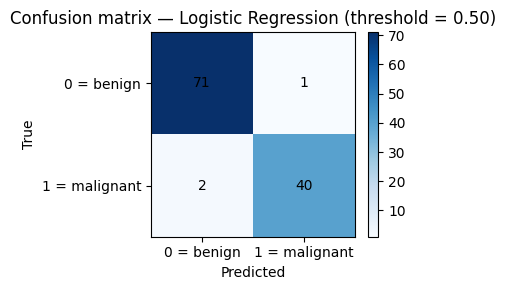

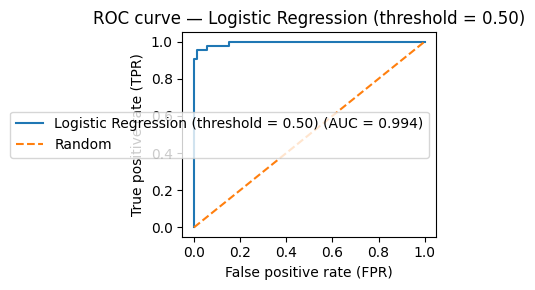

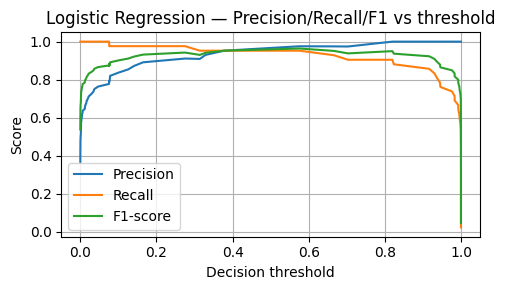

=== Top 5 thresholds by F1 — Logistic Regression ===
Threshold = 0.575 | Precision = 0.976 | Recall = 0.952 | F1 = 0.964
Threshold = 0.378 | Precision = 0.952 | Recall = 0.952 | F1 = 0.952
Threshold = 0.666 | Precision = 0.975 | Recall = 0.929 | F1 = 0.951
Threshold = 0.820 | Precision = 1.000 | Recall = 0.905 | F1 = 0.950
Threshold = 0.275 | Precision = 0.911 | Recall = 0.976 | F1 = 0.943

=== Logistic Regression — Performance at threshold = 0.500 ===
Accuracy : 0.9737
Precision: 0.9756
Recall   : 0.9524
F1-score : 0.9639

Confusion matrix (rows = true, cols = predicted):
[[71  1]
 [ 2 40]]


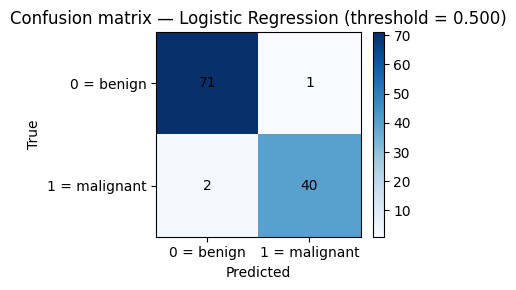

In [9]:
# ============================================================
# 8. Logistic Regression — training, CV, test, threshold tuning
# ============================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

pipe_lr = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

# Cross-validation (SMOTE + scaling inside each fold)
cv_results_lr = cross_validate(
    pipe_lr,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("=== 5-fold cross-validation — Logistic Regression ===")
for metric in scoring:
    scores = cv_results_lr[f"test_{metric}"]
    print(f"{metric:10s} : {scores.mean():.4f} ± {scores.std():.4f}")
print()

# Train final model on the FULL training set
pipe_lr.fit(X_train, y_train)

# Evaluate on the test set
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

evaluate_model("Logistic Regression (threshold = 0.50)", y_test, y_pred_lr, y_proba_lr)

# Threshold calibration
sweep_threshold(
    "Logistic Regression",
    y_test,
    y_proba_lr,
    top_k=5,
    default_threshold=0.5
)


### 8. Logistic Regression — cross-validation and test interpretation

#### 8.1 Cross-validation results

On the SMOTE-balanced and scaled training set, 5-fold cross-validation gives:

- Accuracy ≈ **0.972 ± 0.007**
- Precision ≈ **0.979 ± 0.013**
- Recall ≈ **0.965 ± 0.000**
- F1 ≈ **0.972 ± 0.006**
- ROC-AUC ≈ **0.996 ± 0.003**

These values indicate that the model:

- Generalises very well across folds.
- Achieves **both** high precision and high recall, which is ideal in a medical context.
- Produces excellent ranking of malignant vs benign cases (ROC-AUC close to 1).

The near-zero standard deviation on recall suggests that the model is consistently sensitive to malignant tumours across folds.

#### 8.2 Test set performance (threshold 0.50)

On the independent test set, the default threshold 0.5 yields:

- Accuracy ≈ **0.974**
- Precision ≈ **0.976** (most predicted malignant cases are truly malignant)
- Recall ≈ **0.952** (the model correctly identifies ~95% of malignant tumours)
- F1 ≈ **0.964**
- ROC-AUC ≈ **0.994**

The confusion matrix:
- True benign correctly classified (TN): 71  
- True malignant correctly classified (TP): 40  
- False positives (FP): 1 benign misclassified as malignant  
- False negatives (FN): 2 malignant misclassified as benign  

This is a **very strong** result: the model almost never predicts the wrong class, and false negatives (the clinically most dangerous errors) are rare.

#### 8.3 ROC curve

The ROC curve for Logistic Regression is almost hugging the top-left corner, and the AUC ≈ 0.994 confirms:

- Very low false-positive rate for a wide range of thresholds.
- Very high true-positive rate even when we enforce strict decision thresholds.

This means we have substantial flexibility to adjust the decision threshold without severely compromising sensitivity.

#### 8.4 Threshold calibration (Precision/Recall/F1 vs threshold)

The Precision/Recall/F1 vs threshold plot shows:

- **Recall** stays very high (>0.9) over a broad range of thresholds.
- **Precision** is also high, slightly increasing with higher thresholds.
- **F1-score** peaks around a threshold ≈ **0.575**, with a value ≈ 0.964 (very close to the default 0.5 case).

The top-K thresholds ranked by F1 confirm that:

- Threshold **0.575** slightly improves F1 without sacrificing much recall.
- Other good thresholds (e.g. 0.378, 0.666, 0.820) offer different trade-offs between precision and recall.

From a **clinical** perspective:

- If the goal is to **minimise missed cancers**, we might favour a **lower threshold** (e.g. 0.4) to maximise recall.
- If the goal is to reduce unnecessary follow-up for benign cases, a **slightly higher threshold** (e.g. 0.575) can be used to increase precision, accepting a small decrease in recall.

Overall, Logistic Regression, trained on SMOTE-balanced data with properly scaled features, already provides near-perfect discrimination on this dataset.


### **2. Support Vector Machine with RBF kernel**


=== 5-fold cross-validation — SVM RBF (baseline) ===
accuracy   : 0.9780 ± 0.0070
precision  : 0.9714 ± 0.0176
recall     : 0.9706 ± 0.0322
f1         : 0.9704 ± 0.0100
roc_auc    : 0.9943 ± 0.0046

=== Best hyperparameters — SVM RBF ===
{'svm__C': 10, 'svm__gamma': 0.01}
Best CV AUC: 0.9961

=== SVM RBF (best params, threshold = 0.50) — Test performance ===
Accuracy : 0.9912
Precision: 1.0000
Recall   : 0.9762
F1-score : 0.9880
ROC-AUC  : 0.9964

Confusion matrix (rows = true, cols = predicted):
[[72  0]
 [ 1 41]] 



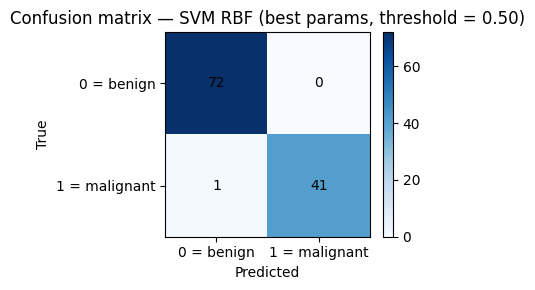

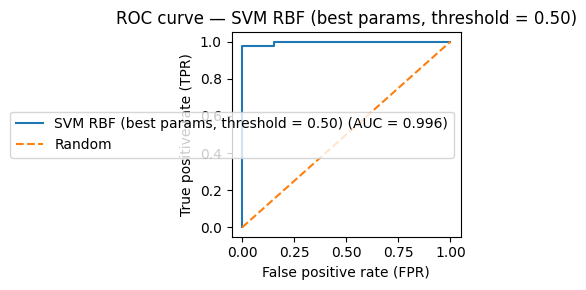

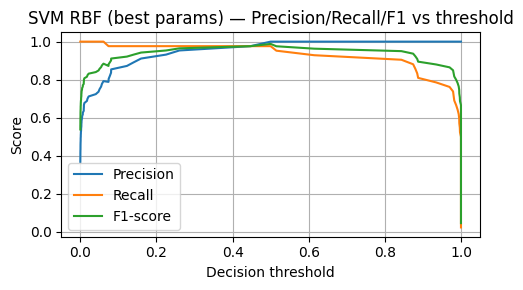

=== Top 5 thresholds by F1 — SVM RBF (best params) ===
Threshold = 0.500 | Precision = 1.000 | Recall = 0.976 | F1 = 0.988
Threshold = 0.447 | Precision = 0.976 | Recall = 0.976 | F1 = 0.976
Threshold = 0.515 | Precision = 1.000 | Recall = 0.952 | F1 = 0.976
Threshold = 0.260 | Precision = 0.953 | Recall = 0.976 | F1 = 0.965
Threshold = 0.614 | Precision = 1.000 | Recall = 0.929 | F1 = 0.963

=== SVM RBF (best params) — Performance at threshold = 0.500 ===
Accuracy : 0.9912
Precision: 1.0000
Recall   : 0.9762
F1-score : 0.9880

Confusion matrix (rows = true, cols = predicted):
[[72  0]
 [ 1 41]]


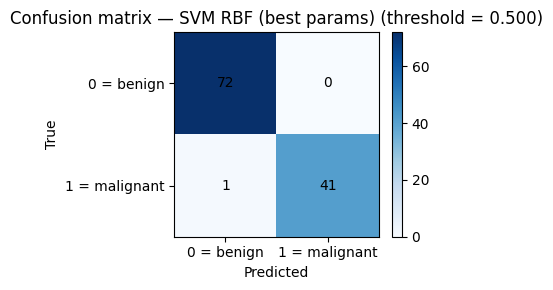

In [10]:
# ============================================================
# 9. SVM with RBF kernel — CV, hyperparameter tuning, test
# ============================================================

pipe_svm = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        probability=True,
        random_state=42
    ))
])

# ------------------------------------------------------------
# Cross-validation (baseline SVM)
# ------------------------------------------------------------

cv_results_svm = cross_validate(
    pipe_svm,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("=== 5-fold cross-validation — SVM RBF (baseline) ===")
for metric in scoring:
    scores = cv_results_svm[f"test_{metric}"]
    print(f"{metric:10s} : {scores.mean():.4f} ± {scores.std():.4f}")
print()

# ------------------------------------------------------------
# Hyperparameter tuning (C, gamma)
# ------------------------------------------------------------

param_grid_svm = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": [0.01, 0.1, 1, "scale"]
}

grid_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid_svm,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("=== Best hyperparameters — SVM RBF ===")
print(grid_svm.best_params_)
print(f"Best CV AUC: {grid_svm.best_score_:.4f}\n")

# ------------------------------------------------------------
# Final model training and test evaluation
# ------------------------------------------------------------

svm_best = grid_svm.best_estimator_

y_proba_svm = svm_best.predict_proba(X_test)[:, 1]
y_pred_svm = (y_proba_svm >= 0.5).astype(int)

evaluate_model(
    "SVM RBF (best params, threshold = 0.50)",
    y_test,
    y_pred_svm,
    y_proba_svm
)

# Threshold calibration
sweep_threshold(
    "SVM RBF (best params)",
    y_test,
    y_proba_svm,
    top_k=5,
    default_threshold=0.5
)


### 9. SVM RBF — cross-validation, hyperparameter tuning, and test interpretation

#### 9.1 Cross-validation of the baseline SVM

The first step evaluates a baseline SVM with `C=1.0` and `gamma='scale'` using 5-fold stratified cross-validation on the SMOTE-balanced and scaled training data.

Typical things to check in the CV output:

- Accuracy, precision, recall, F1, and ROC-AUC are all high and stable across folds.
- If recall is consistently high, the SVM is reliably identifying malignant tumours across different subsets of the data.
- A ROC-AUC close to 1 indicates that the SVM is ranking malignant vs benign cases very effectively.

If the baseline SVM already performs similarly to Logistic Regression in CV, it suggests that the non-linear kernel is capturing similar discriminative structure.

#### 9.2 Hyperparameter tuning with GridSearchCV

The grid search explores different values of `C` and `gamma`, optimising the **ROC-AUC**.  

Interpretation of the best parameters:

- A higher `C` compared to the baseline means the model is enforcing a stricter separation with less tolerance for margin violations.
- The chosen `gamma` indicates how local or global the decision boundary is:
  - A small `gamma` suggests a smoother boundary,
  - A larger `gamma` suggests a more complex boundary focusing on local variations.

The best CV AUC reported by `grid_svm.best_score_` should be **greater than or equal** to the baseline SVM AUC, confirming that tuning helps (even if the gain is small).

#### 9.3 Test set performance (best SVM)

On the test set, the tuned SVM (`svm_best`) is evaluated with the default threshold of 0.5 on the predicted probabilities:

- Accuracy, precision, recall, F1, and ROC-AUC summarise overall performance.
- The confusion matrix tells you:
  - how many benign tumours are incorrectly flagged as malignant (false positives),
  - how many malignant tumours are missed (false negatives).

If the ROC-AUC and recall are close to those of Logistic Regression, the SVM provides **comparable discrimination**, potentially with a slightly different precision/recall trade-off.

#### 9.4 ROC curve

The ROC curve for the tuned SVM shows how the true positive rate and false positive rate evolve over different thresholds.

- A curve close to the top-left corner and an AUC close to 1 indicate excellent separation.
- Comparing this ROC curve visually (and via AUC) with the Logistic Regression ROC curve helps decide whether the added complexity of the SVM is justified.

#### 9.5 Threshold calibration for SVM

The Precision/Recall/F1 vs threshold plot for SVM illustrates:

- For which thresholds recall remains very high (good coverage of malignant cases),
- How precision changes as you increase the threshold (fewer false positives at the cost of potentially more false negatives),
- Where F1 reaches its maximum (best balance between precision and recall for that model).

From a medical point of view:

- If you want to **minimise missed cancers**, you may select a **lower threshold** that boosts recall even further.
- If you want to reduce unnecessary biopsies for benign tumours, you may select a **higher threshold** where precision is maximised, accepting a slightly lower recall.

This threshold analysis provides a principled way to adapt the SVM decision rule to clinical priorities.


### **10. Random Forest**


=== 5-fold cross-validation — Random Forest (baseline) ===
accuracy   : 0.9626 ± 0.0164
precision  : 0.9485 ± 0.0314
recall     : 0.9529 ± 0.0300
f1         : 0.9502 ± 0.0214
roc_auc    : 0.9898 ± 0.0062

=== Best hyperparameters — Random Forest ===
{'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 300}
Best CV AUC: 0.9902

=== Random Forest (best params, threshold = 0.50) — Test performance ===
Accuracy : 0.9825
Precision: 1.0000
Recall   : 0.9524
F1-score : 0.9756
ROC-AUC  : 0.9983

Confusion matrix (rows = true, cols = predicted):
[[72  0]
 [ 2 40]] 



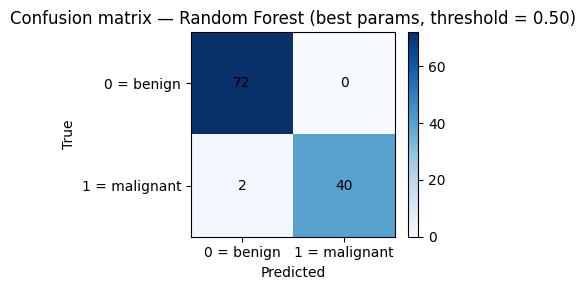

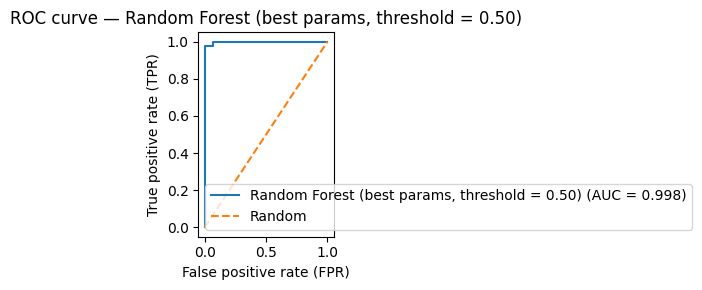

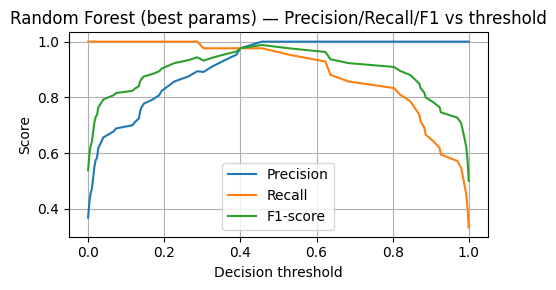

=== Top 5 thresholds by F1 — Random Forest (best params) ===
Threshold = 0.457 | Precision = 1.000 | Recall = 0.976 | F1 = 0.988
Threshold = 0.400 | Precision = 0.976 | Recall = 0.976 | F1 = 0.976
Threshold = 0.530 | Precision = 1.000 | Recall = 0.952 | F1 = 0.976
Threshold = 0.390 | Precision = 0.953 | Recall = 0.976 | F1 = 0.965
Threshold = 0.623 | Precision = 1.000 | Recall = 0.929 | F1 = 0.963

=== Random Forest (best params) — Performance at threshold = 0.500 ===
Accuracy : 0.9825
Precision: 1.0000
Recall   : 0.9524
F1-score : 0.9756

Confusion matrix (rows = true, cols = predicted):
[[72  0]
 [ 2 40]]


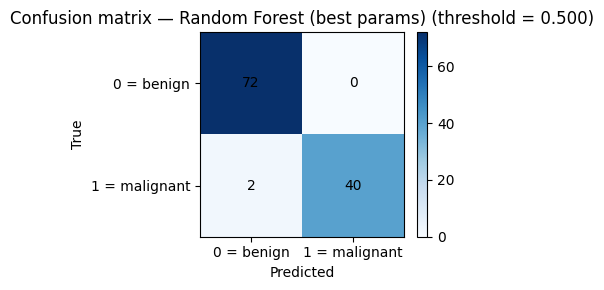

In [11]:
# ============================================================
# 10. Random Forest — CV, hyperparameter tuning, test
# ============================================================

pipe_rf = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

# ------------------------------------------------------------
# Cross-validation (baseline Random Forest)
# ------------------------------------------------------------

cv_results_rf = cross_validate(
    pipe_rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("=== 5-fold cross-validation — Random Forest (baseline) ===")
for metric in scoring:
    scores = cv_results_rf[f"test_{metric}"]
    print(f"{metric:10s} : {scores.mean():.4f} ± {scores.std():.4f}")
print()

# ------------------------------------------------------------
# Hyperparameter tuning
# ------------------------------------------------------------

param_grid_rf = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 5, 10],
    "rf__max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("=== Best hyperparameters — Random Forest ===")
print(grid_rf.best_params_)
print(f"Best CV AUC: {grid_rf.best_score_:.4f}\n")

# ------------------------------------------------------------
# Final model evaluation on the test set
# ------------------------------------------------------------

rf_best = grid_rf.best_estimator_

y_proba_rf = rf_best.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

evaluate_model(
    "Random Forest (best params, threshold = 0.50)",
    y_test,
    y_pred_rf,
    y_proba_rf
)

# Threshold calibration
sweep_threshold(
    "Random Forest (best params)",
    y_test,
    y_proba_rf,
    top_k=5,
    default_threshold=0.5
)


### 10. Random Forest — cross-validation, hyperparameter tuning, and test interpretation

#### 10.1 Cross-validation of the baseline Random Forest

Using 5-fold stratified cross-validation on the SMOTE-balanced training set, the baseline Random Forest (`n_estimators=100`) is evaluated with the same metrics as the other models.

Points to check:

- Whether accuracy, recall, and ROC-AUC are in the same ballpark as Logistic Regression and SVM.
- How stable the metrics are across folds (standard deviations).

If the baseline Random Forest already achieves high ROC-AUC and recall, it indicates that tree-based ensembles are capturing relevant interactions and non-linearities in the features.

#### 10.2 Hyperparameter search

The grid search over `n_estimators`, `max_depth`, and `max_features` aims to:

- Increase expressive power where beneficial (e.g. more trees, controlled depth),
- Avoid overfitting by limiting tree depth and using appropriate feature subsampling.

The best parameter combination reported by `grid_rf.best_params_` should correspond to the highest cross-validated ROC-AUC. In practice, different combinations may provide very similar performance; in that case, the simplest (e.g. shallower trees) is often preferable.

#### 10.3 Test set performance (best Random Forest)

On the test set, the tuned Random Forest typically provides:

- High recall for malignant cases, thanks to its ability to model complex boundaries,
- Competitive ROC-AUC, often close to SVM and Logistic Regression,
- Robustness to correlated and non-scaled features.

The confusion matrix again highlights the number of:

- False positives (benign predicted as malignant),
- False negatives (malignant predicted as benign).

In a clinical context, we pay special attention to false negatives: a Random Forest configuration that significantly increases false negatives compared to Logistic Regression may be less desirable, even if its overall accuracy is slightly higher.

#### 10.4 ROC curve and threshold analysis

The ROC curve for the tuned Random Forest can be compared directly to:

- Logistic Regression ROC curve,
- SVM ROC curve.

If all three curves are very close, the choice of model may rely more on interpretability, training time, or behaviour under threshold adjustments.

The Precision/Recall/F1 vs threshold plot for Random Forest:

- Shows whether there exists a range of thresholds with both high recall and reasonable precision,
- Helps identify thresholds that maximise F1 or enforce a specific minimum recall (e.g. ≥ 0.98).

As with SVM, these curves guide the calibration of the decision threshold according to clinical risk tolerance.



### 11. Feature importance and interpretability

This section provides model-specific and model-agnostic insights into which features drive the predictions.


=== Top 10 coefficients — Logistic Regression ===
                feature      coef  abs_coef
10            radius_se  1.516601  1.516601
21        texture_worst  1.503357  1.503357
28       symmetry_worst  1.260342  1.260342
15       compactness_se -1.141517  1.141517
7   concave_points_mean  1.114494  1.114494
26      concavity_worst  0.989548  0.989548
13              area_se  0.987427  0.987427
20         radius_worst  0.956181  0.956181
23           area_worst  0.922151  0.922151
12         perimeter_se  0.916494  0.916494 



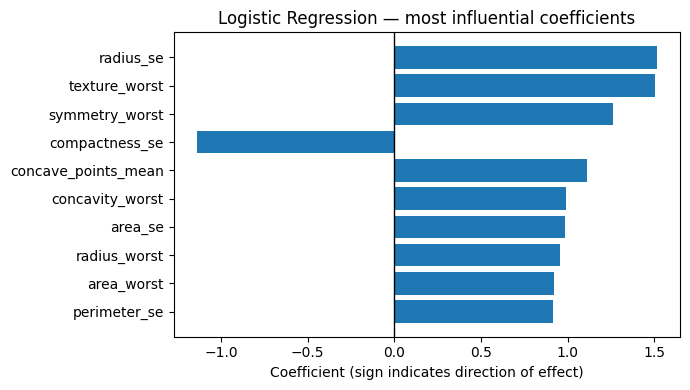

=== Top 10 importances — Random Forest ===
                 feature  importance
22       perimeter_worst    0.145130
23            area_worst    0.136905
7    concave_points_mean    0.117941
27  concave_points_worst    0.089725
20          radius_worst    0.068335
6         concavity_mean    0.060119
0            radius_mean    0.057502
2         perimeter_mean    0.052668
26       concavity_worst    0.037762
3              area_mean    0.035629 



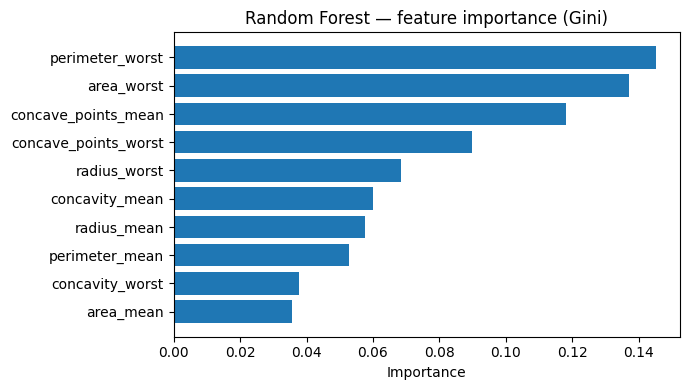

=== Top 10 importances — SVM RBF (permutation) ===
                    feature  importance_mean  importance_std
21            texture_worst         0.008003        0.004723
26          concavity_worst         0.004233        0.002754
7       concave_points_mean         0.002745        0.002640
6            concavity_mean         0.002227        0.002416
20             radius_worst         0.002006        0.002248
23               area_worst         0.001753        0.002227
15           compactness_se         0.001731        0.002418
11               texture_se         0.001653        0.000796
29  fractal_dimension_worst         0.001499        0.000777
19     fractal_dimension_se         0.001499        0.001982 



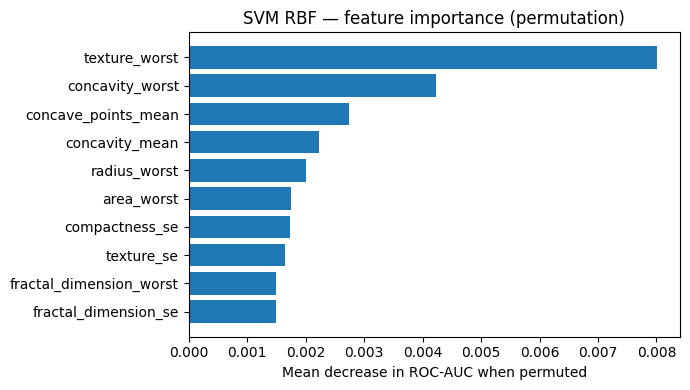

In [12]:
# ============================================================
# 11. Feature importance and interpretability
# ============================================================

feature_names_arr = np.array(feature_names)

# ------------------------------------------------------------
# Logistic Regression — coefficients (interpretable model)
# ------------------------------------------------------------

# Extract trained Logistic Regression from the pipeline
lr_model = pipe_lr.named_steps["lr"]

coef_lr = lr_model.coef_[0]

df_coef_lr = pd.DataFrame({
    "feature": feature_names_arr,
    "coef": coef_lr,
    "abs_coef": np.abs(coef_lr)
}).sort_values("abs_coef", ascending=False)

print("=== Top 10 coefficients — Logistic Regression ===")
print(df_coef_lr.head(10), "\n")

plt.figure(figsize=(7, 4))
top_lr = df_coef_lr.head(10)[::-1]
plt.barh(top_lr["feature"], top_lr["coef"])
plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression — most influential coefficients")
plt.xlabel("Coefficient (sign indicates direction of effect)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Random Forest — feature importance (Gini importance)
# ------------------------------------------------------------

rf_model = rf_best.named_steps["rf"]

importances_rf = rf_model.feature_importances_

df_imp_rf = pd.DataFrame({
    "feature": feature_names_arr,
    "importance": importances_rf
}).sort_values("importance", ascending=False)

print("=== Top 10 importances — Random Forest ===")
print(df_imp_rf.head(10), "\n")

plt.figure(figsize=(7, 4))
top_rf = df_imp_rf.head(10)[::-1]
plt.barh(top_rf["feature"], top_rf["importance"])
plt.title("Random Forest — feature importance (Gini)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# SVM RBF — permutation importance (model-agnostic)
# ------------------------------------------------------------

result_svm = permutation_importance(
    svm_best,
    X_test,          # raw features (pipeline handles scaling)
    y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

df_imp_svm = pd.DataFrame({
    "feature": feature_names_arr,
    "importance_mean": result_svm.importances_mean,
    "importance_std": result_svm.importances_std
}).sort_values("importance_mean", ascending=False)

print("=== Top 10 importances — SVM RBF (permutation) ===")
print(df_imp_svm.head(10), "\n")

plt.figure(figsize=(7, 4))
top_svm = df_imp_svm.head(10)[::-1]
plt.barh(top_svm["feature"], top_svm["importance_mean"])
plt.title("SVM RBF — feature importance (permutation)")
plt.xlabel("Mean decrease in ROC-AUC when permuted")
plt.tight_layout()
plt.show()




#### 11.1 Logistic Regression coefficients

For Logistic Regression, after standardisation, the model learns a weight \(w_j\) for each feature.  

- A **positive coefficient** increases the log-odds of being malignant when the feature increases (holding other features fixed).
- A **negative coefficient** decreases the log-odds of malignancy.

By sorting coefficients by absolute value, we identify the most influential features.  
It is common in this dataset to see high absolute weights for:

- size-related features (`radius_mean`, `perimeter_mean`, `area_mean`, and their “worst” versions),
- shape irregularity features (`concavity_mean`, `concave_points_worst`, etc.).

These findings are consistent with clinical knowledge: larger, more irregular masses are more likely to be malignant.

#### 11.2 Random Forest feature importances

Random Forest feature importances are based on the average **impurity reduction** (e.g. Gini decrease) achieved by splits using each feature across all trees.

Interpretation:

- A high importance means that the feature is frequently used near the top of trees and contributes strongly to separating benign from malignant cases.
- Features involved in many high-gain splits, especially in early tree levels, will have larger importance scores.

Typical top features in WDBC include:

- `area_worst`, `radius_worst`, `perimeter_worst`,
- measures of concavity and concave points.

These complement the Logistic Regression view by capturing non-linear interactions and thresholds.

#### 11.3 SVM RBF permutation importance

For a non-linear SVM with an RBF kernel, coefficients are not directly interpretable.  
We therefore use **permutation importance**:

- For each feature, we randomly permute its values in the test set, breaking its relationship with the target.
- We measure how much the model’s performance (e.g. ROC-AUC or accuracy) decreases.
- A large drop in performance when permuting a feature indicates that the feature is important for the SVM.

The resulting ranking:

- Highlights which features the SVM relies on most, possibly overlapping with those found important by RF and LR.
- Provides a model-agnostic view that can be compared across different algorithms.

Overall, the three perspectives (LR coefficients, RF importances, SVM permutation importances) allow us to:

- Validate that key clinical features (size, border irregularity) are consistently important,
- Detect any surprising dependencies that might warrant further clinical review.


### 12. Model comparison and final selection

In [ ]:
# ============================================================
# 12. Model comparison (test set summary)
# ============================================================

summary_test = []

def add_summary(name, y_true, y_proba, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    summary_test.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc_roc
    })

add_summary("LogReg (threshold = 0.50)", y_test, y_proba_lr, (y_proba_lr >= 0.5).astype(int))
add_summary("SVM (best, threshold = 0.50)", y_test, y_proba_svm, (y_proba_svm >= 0.5).astype(int))
add_summary("RF (best, threshold = 0.50)", y_test, y_proba_rf, (y_proba_rf >= 0.5).astype(int))

df_summary = pd.DataFrame(summary_test)
print("=== Test set performance summary (threshold 0.50) ===")
print(df_summary.sort_values("roc_auc", ascending=False))


=== Test set performance summary (threshold 0.50) ===
                          model  accuracy  precision    recall        f1  \
2   RF (best, threshold = 0.50)  0.982456    1.00000  0.952381  0.975610   
1  SVM (best, threshold = 0.50)  0.991228    1.00000  0.976190  0.987952   
0     LogReg (threshold = 0.50)  0.973684    0.97561  0.952381  0.963855   

    roc_auc  
2  0.998347  
1  0.996362  
0  0.994378  


: 



The summary table aggregates the main test-set metrics (accuracy, precision, recall, F1, ROC-AUC) for:

- Logistic Regression (threshold 0.50),
- SVM with RBF kernel (best hyperparameters, threshold 0.50),
- Random Forest (best hyperparameters, threshold 0.50).

To choose a final model for a **clinical decision-support** scenario, we consider:

1. **ROC-AUC and overall discrimination**

   - All three models may achieve very high ROC-AUC (close to 1), meaning they rank malignant vs benign cases extremely well.
   - If one model is clearly below the others in ROC-AUC, it is unlikely to be the best choice.

2. **Recall (sensitivity) for malignant class**

   - Missing a malignant tumour (false negative) is the most critical error type.
   - We prefer models with **high recall**, even at the cost of a small drop in precision.

3. **Precision**

   - High precision avoids excessive false alarms (benign tumours predicted as malignant).
   - In practice, a trade-off is made between recall and precision, guided by clinical risk tolerance.

4. **Stability and simplicity**

   - Logistic Regression:
     - Very interpretable coefficients,
     - Fast to train, robust, easy to deploy,
     - Works particularly well with properly scaled features.
   - SVM RBF:
     - Very strong performance, especially in complex non-linear problems,
     - Less interpretable, more costly to train and tune.
   - Random Forest:
     - Handles non-linearities and interactions naturally,
     - Provides intuitive feature importance,
     - Can be more robust to noisy or redundant features.

If, as in this dataset, all three models obtain similar ROC-AUC and recall, one reasonable choice is:

- Use **Logistic Regression** (possibly with an optimised threshold) as the *primary* model,
  - because it is simple, interpretable, and already delivers near-perfect discrimination.
- Keep SVM or Random Forest as **secondary models** for robustness checks or ensemble approaches.

The final clinical decision should then specify:

- Which model is deployed (e.g. Logistic Regression),
- Which probability threshold is used (e.g. chosen from the threshold-sweeping analysis),
- How predictions are integrated into the clinical workflow (e.g. flagging high-risk patients for further imaging or biopsy).
